In [4]:
using DIVAnd
using Dates
using NCDatasets
using Test
using PyPlot
using Statistics
using DelimitedFiles
using Glob
const plt = PyPlot
using PyCall
include("./ME4OH.jl")
include("./config.jl")

ccrs = pyimport("cartopy.crs")
myproj = ccrs.PlateCarree(central_longitude=180.0)

[ Info: File already downloaded


PyObject <Projected CRS: +proj=eqc +ellps=WGS84 +a=6378137.0 +lon_0=180.0 + ...>
Name: unknown
Axis Info [cartesian]:
- E[east]: Easting (unknown)
- N[north]: Northing (unknown)
- h[up]: Ellipsoidal height (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unknown
- method: Equidistant Cylindrical
Datum: unknown
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

## Read all the data together

In [5]:
thetimeperiod = timeperiod1
datadirdisk = "/media/ctroupin/T7 Shield/000060826v009/data/en4.1.1/$(thetimeperiod[1])-$(thetimeperiod[end])"
datafilelist = ME4OH.get_filelist(datadirdisk);

[ Info: Found 432 files


In [25]:
@time lon, lat, dates, dohc, adohc, dadohc, dohc_mask, ts_bounds, depth_level_thickness = 
ME4OH.read_profile(datafilelist);
lon[lon.< 20.] .+= 360.;
@info("Read $(length(lon)) observations")

  6.932652 seconds (1.37 M allocations: 14.778 GiB, 3.80% gc time)


[ Info: Read 5710432 observations


## Plots to check

In [26]:
# Loop on layer
for iii = 1:1
    # Loop on month
    for mm = 1:2
        goodtime = findall(Dates.month.(dates) .== mm)

        fig = plt.figure(figsize=(12, 8))
        ax = plt.subplot(111, projection=myproj, frameon=false)
        ax.set_global()
        ax.coastlines(lw=.5)
        scat = ax.scatter(lon[goodtime], lat[goodtime], s=1, c=dohc[iii,goodtime], 
            cmap=plt.cm.RdYlBu_r, transform=ccrs.PlateCarree())
        cb = plt.colorbar(scat, shrink=.6)
        cb.set_label("TJ/m²", rotation=0, ha="left")
        ax.set_title("Ocean heat content density in layer $(depthlayers[iii][1]) - $(depthlayers[iii][end]) m\n$(Dates.monthname(mm)) $(thetimeperiod[1]) - $(thetimeperiod[end])")
        plt.savefig(joinpath(figdir, "dohc_layer$(iii)_month$(lpad(mm, 2, '0'))_period_$(thetimeperiod[1])-$(thetimeperiod[end])"))
        plt.close()    
    end
end 

In [223]:
depthgrid = [depthlayer1[end], depthlayer2[end], depthlayer3[end]]
xi, yi, mask_dohc = DIVAnd.load_mask(bathyfile, true, longrid, latgrid, depthgrid);        
_, (pm, pn), (xi, yi) = DIVAnd_rectdom(longrid, latgrid);

In [224]:
Float64.(dohc[1:length(depthgrid),:]'[:]) == dohc3

false

In [225]:
lon3 = Float64.(repeat(lon, length(depthgrid)));
lat3 = Float64.(repeat(lat, length(depthgrid)));
dates3 = repeat(dates, length(depthgrid));
depth3 = repeat(depthgrid, outer=[1,length(lon)]);
depth3 = depth3'[:]
dohc3 = Float64.(dohc[1:length(depthgrid),:]);

In [226]:
dohc3

3×5710432 Matrix{Float64}:
   0.341889    0.34192     0.342356  …  0.348815  0.34639   0.3496
 NaN           0.473761  NaN            0.479802  0.477197  0.482559
 NaN         NaN         NaN            1.50407   1.50342   1.50804

In [227]:
length(lon3), length(lat3), length(dates3), length(depth3), size(dohc3[:])

(17131296, 17131296, 17131296, 17131296, (17131296,))

### Prepare the time grid 
According to the time period specified in `config.jl`.

In [228]:
yearlist = [timeperiod1]
monthlist = 1:1
TSbackground = DIVAnd.TimeSelectorYearListMonthList(yearlist, monthlist)
length(TSbackground)

1

In [229]:
sz = (length(longrid), length(latgrid), length(depthgrid))
lenx = fill(1000_000., sz)
leny = fill(1000_000., sz)
lenz = fill(0., sz);
len = (lenx, leny, lenz);
epsilon2 = 10.

10.0

In [ ]:
outputfile = joinpath(mainoutputdir, "test_diva3D.nc")
isfile(outputfile) ? rm(outputfile) : @debug("ok")
@time dbinfo = diva3d((longrid, latgrid, depthgrid, TSbackground),
    (lon3, lat3, depth3, dates3), dohc3[:],
    len, epsilon2,
    outputfile, "dohc",
    bathname=gebco16file,
    fitcorrlen = false,
    moddim=[0,1,0]
    );

[ Info: Creating netCDF file ../output/test_diva3D.nc
[ Info: Time step 1 / 1
┌ Warning: Observations equal to NaN: 264293
└ @ DIVAnd ~/.julia/packages/DIVAnd/BQFGA/src/DIVAnd_obs.jl:45
[ Info: scaled correlation length (min,max) in dimension 1: (1.0e6, 1.0e6)


In [191]:
# Create mask for the considered depth level
_, (pm, pn), (xi, yi) = DIVAnd.DIVAnd_rectdom(longrid, latgrid)
_, _, mask = DIVAnd.load_mask(gebco16file, true, longrid, latgrid, depthlayer1[2])

@time fi, s = DIVAndrun(mask, (pm, pn), (xi, yi), (Float64.(lon3[sel2]), Float64.(lat3[sel2])), 
Float64.(dohc3[sel2]), 15., epsilon2, moddim=[1,0]);

┌ Warning: Observations equal to NaN: 54349
└ @ DIVAnd ~/.julia/packages/DIVAnd/BQFGA/src/DIVAnd_obs.jl:45


  0.863364 seconds (2.40 M allocations: 925.267 MiB, 57.79% gc time)


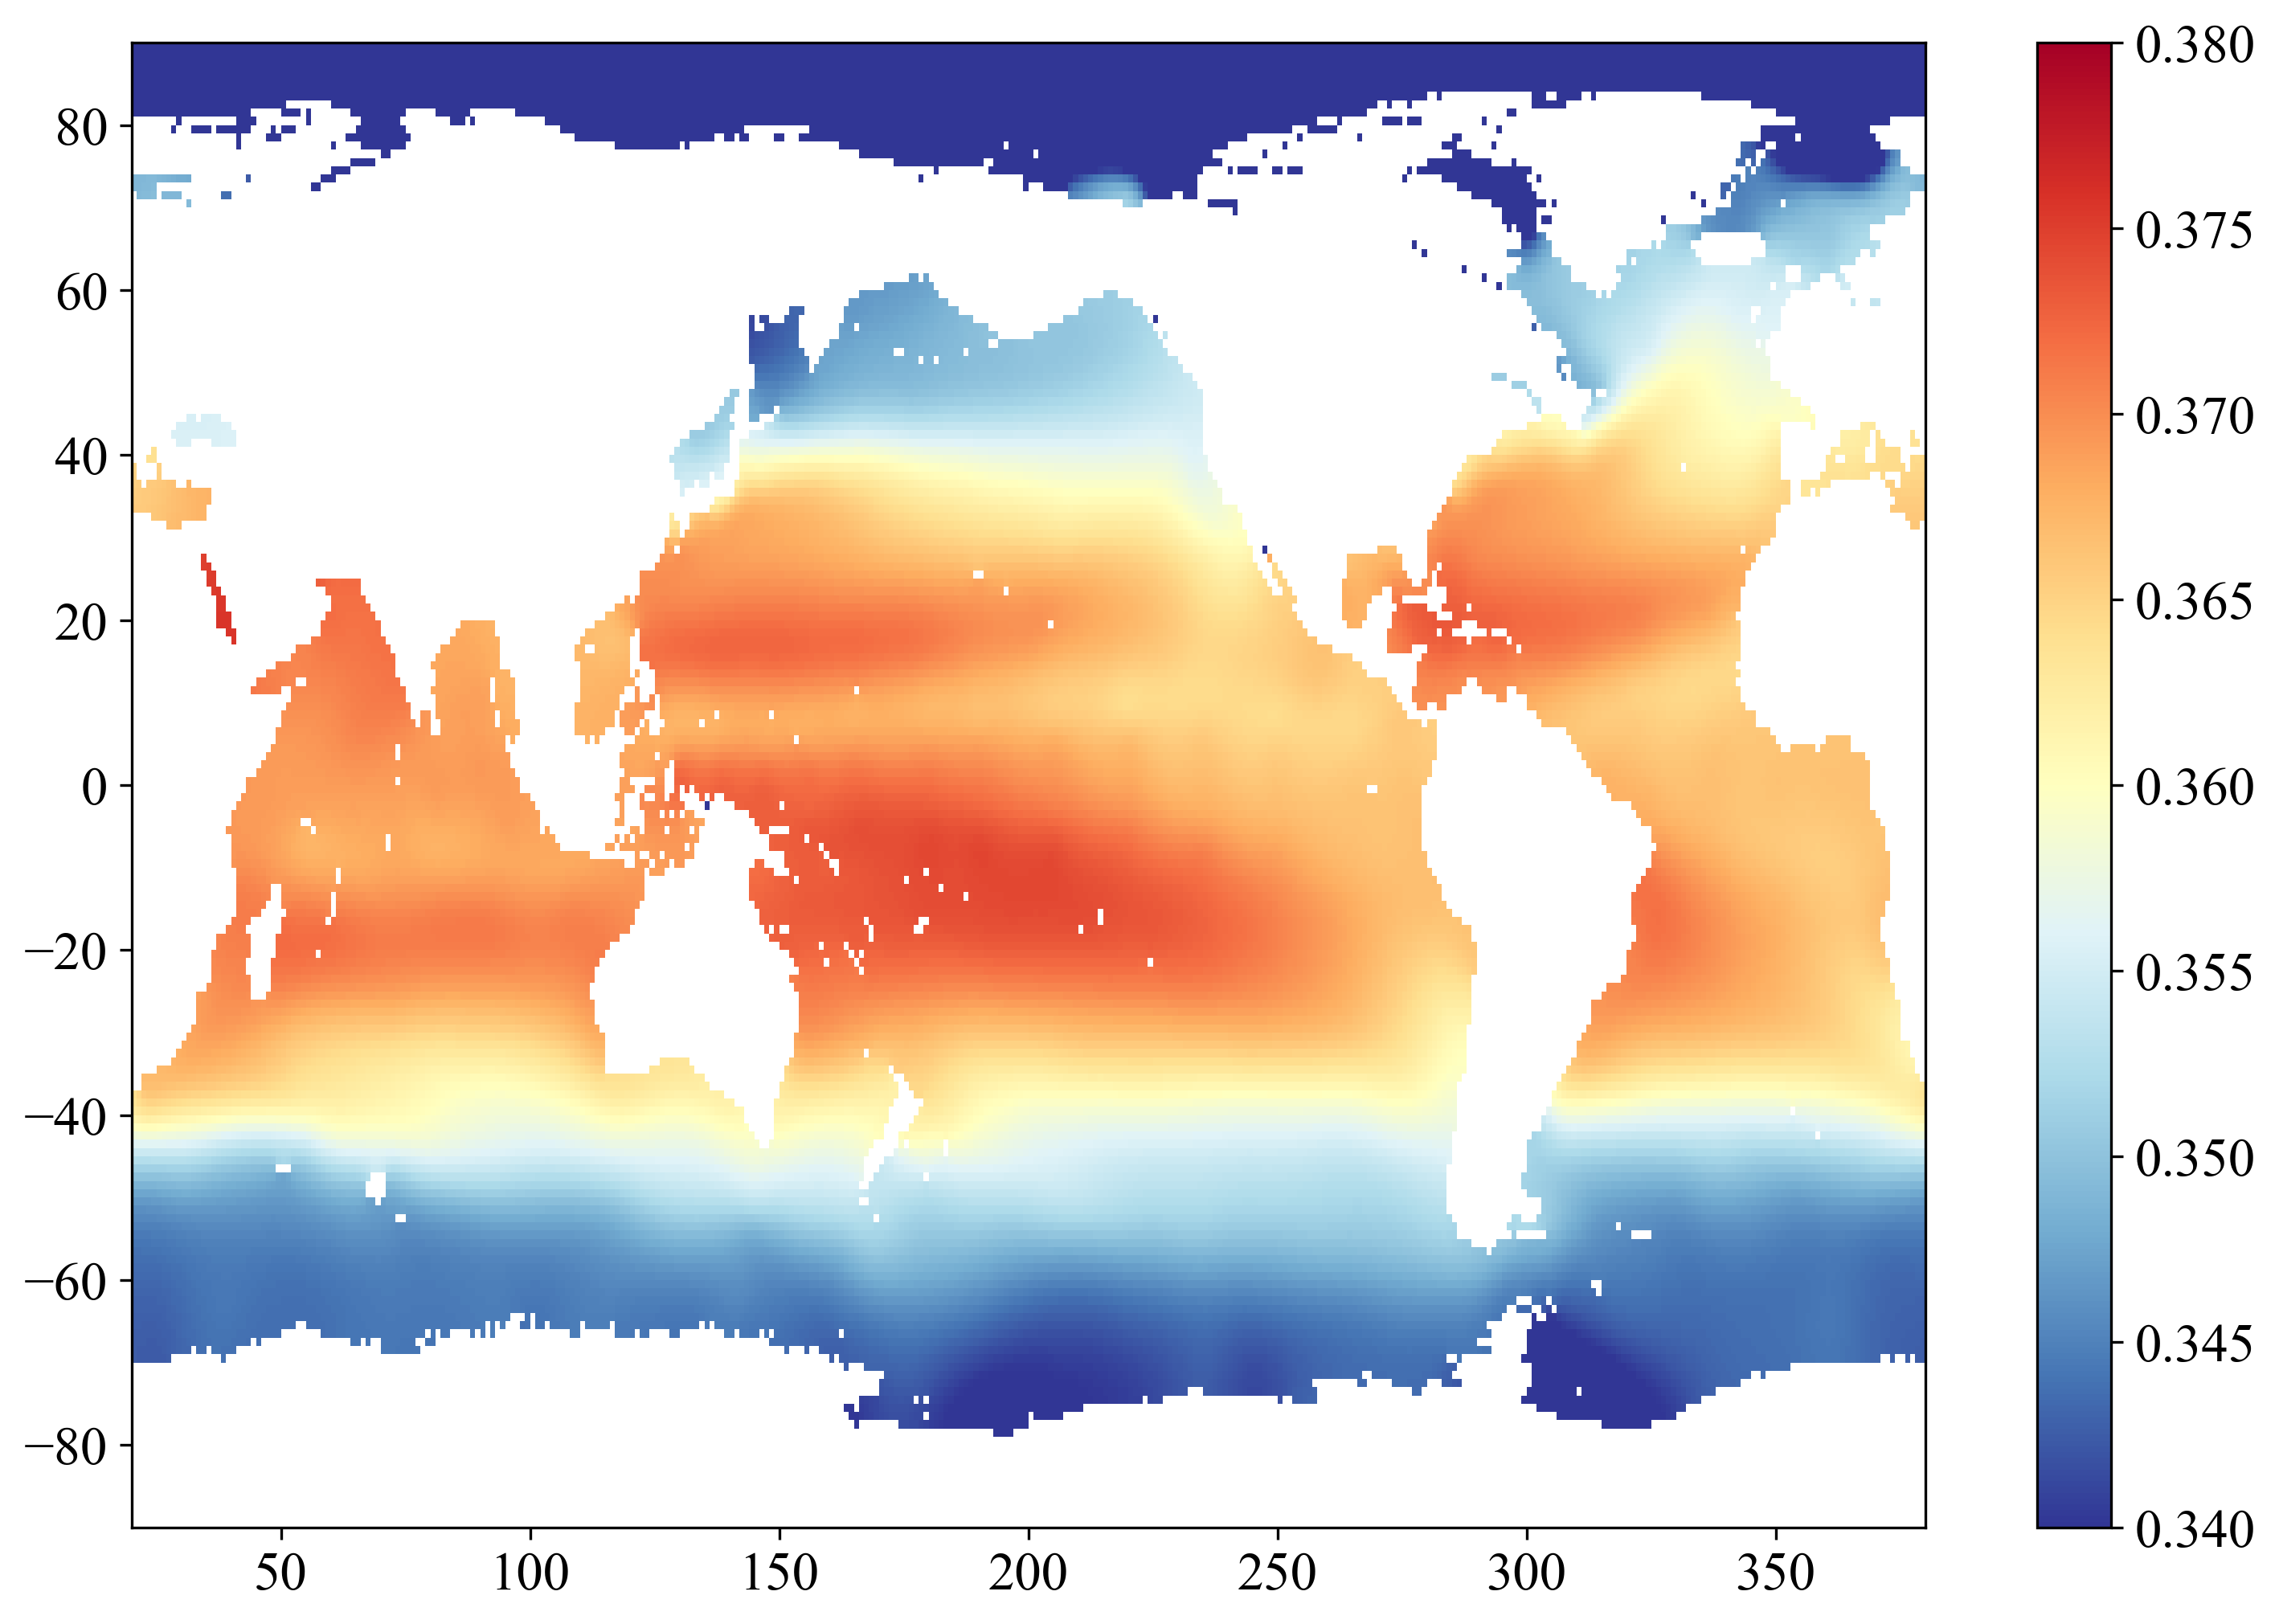

PyObject <matplotlib.colorbar.Colorbar object at 0x701c9a9a2980>

In [100]:
pcm = plt.pcolormesh(longrid, latgrid, fi', vmin=0.34, vmax=0.38, cmap=plt.cm.RdYlBu_r)
plt.colorbar(pcm)

## Perform analysis
### Create the netCDF files that will store the results
The output directory is specified in `config.jl`.

In [7]:
outputfilelist = []
for depthlayer in [depthlayer1, depthlayer2, depthlayer3]
    fname = make_fname(timeperiod1, depthlayer, "A")
    outputfile = joinpath(outputdir, fname)
    isfile(outputfile) ? rm(outputfile) : @debug("OK")
    create_netcdf_results(outputfile, longrid, latgrid, timegrid1)
    
    # Add the residual variables in the netCDF
    add_residuals(outputfile, datafilelist)
    
    # Add file to the list
    push!(outputfilelist, outputfile)
end

LoadError: UndefVarError: `make_fname` not defined

### Loop on the files and the depths

In [8]:
for (ntime, datafile) in enumerate(datafilelist)
    
    # Read observations
    lon, lat, dates, depth, T, S, dohc = read_profile(datafile)
    
    # Modify coordinates
    lon[lon .< 20.] .+= 360
    
    # Loop on the 3 depth levels
    for ii = 1:1
        
        # Select good values (no NaNs)
        obsval = dohc[ii,:]
        goodval = findall(.!isnan.(obsval));
        ngood = length(goodval)
        
        # Perform interpolation
        fi, s = DIVAndrun(mask_dohc[:,:,ii], (pm, pn), (xi, yi), (Float64.(lon[goodval]), 
        Float64.(lat[goodval])), Float64.(obsval[goodval] .- mean(obsval[goodval])), 
        (5., 5.), 10.; moddim=[1,0])
        
        # Compute residuals
        dataresidual = DIVAnd_residual(s, fi)
        
        # Write field and residual in the netCDF
        NCDataset(outputfilelist[ii], "a") do ds
            ds["dohc"][:,:,ntime] = fi
            ds["obslon"][1:ngood,ntime] = lon[goodval]
            ds["obslat"][1:ngood,ntime] = lat[goodval]
            ds["obstime"][1:ngood,ntime] = dates[goodval]
            ds["dohc_residuals"][1:ngood,ntime] = dataresidual
        end
        
        # Make plot
        if doplot
            fig = plt.figure(figsize=(15, 8))
            ax = plt.subplot(121)
            ax.scatter(lon[goodval], lat[goodval], s=3, c=obsval[goodval])
            ax.set_xlim(20., 380.)
            ax = plt.subplot(122)
            ax.pcolormesh(longrid, latgrid, fi' .+ mean(obsval[goodval]))
            ax.set_xlim(20., 380.)
            plt.show()
        end
    end
end

LoadError: UndefVarError: `read_profile` not defined

## Temperature analysis

In [9]:
datafile = datafilelist[1]

"/home/ctroupin/data/ME4OH/data/en4.1.1/1979-2014/full/update/ofam3-jra55.all.EN.4.1.1.f.profiles.g10.197901.update.nc"

In [10]:
lon, lat, dates, depth, T, S, dohc = ME4OH.read_profile(datafile)
lon[lon .< 20.] .+= 360;
obslon, obslat, obsdates, obsdepth, T, S = ME4OH.vectorize_obs(lon, lat, dates, depth, T, S);

In [11]:
length(obslat)

354170

### Set grids
Lon and lat grid are defined in `config.jl`.     
The depth levels are the same as the profiles.

In [12]:
depthgrid = depth;

### Set the analysis parameters

In [13]:
sz = (length(longrid), length(latgrid), length(depthgrid))

lenx = fill(20.,sz)
leny = fill(20.,sz)
lenz = fill(0., sz);
len = (lenx, leny, lenz);
epsilon2 = 5.

5.0

### Run the analysis

In [14]:
_, pmn, xyi = DIVAnd_rectdom(longrid, latgrid, depthgrid);

In [15]:
xi, yi, mask = load_mask(bathyfile, true, longrid, latgrid, depthgrid);

In [16]:
@time Tinterp, s = DIVAndrun(mask, pmn, xyi, (obslon, obslat, obsdepth), Float64.(T .- mean(T)),
len, epsilon2, moddim=[1,0,0]);

LoadError: InterruptException:

In [18]:
dindex = 25
xi, yi, mask2D = DIVAnd.load_mask(bathyfile, true, longrid, latgrid, depthgrid[dindex]);        
_, (pm, pn), (xi, yi) = DIVAnd_rectdom(longrid, latgrid);
depthsel = findall(obsdepth .== depthgrid[dindex])
@time Tinterp2, s2 = DIVAndrun(mask2D, (pm, pn), (xi, yi), (obslon[depthsel], obslat[depthsel]), 
Float64.(T[depthsel] .- mean(T[depthsel])), 
(20., 20.), epsilon2, moddim=[1,0]);

vmin = quantile(T[depthsel], 0.02)
vmax = quantile(T[depthsel], 0.98)

fig = plt.figure(figsize=(18, 6))
ax = plt.subplot(131)
pcm = plt.pcolormesh(longrid, latgrid, mean(T) .+ Tinterp[:,:,dindex]', 
cmap=plt.cm.RdYlBu_r, vmin=vmin, vmax=vmax, zorder=5)
ax.pcolormesh(longrid, latgrid, mask[:,:,dindex]', cmap=plt.cm.binary_r, zorder=3)
plt.colorbar(pcm)
ax.set_xlim(20., 380.)
ax.set_title("DIVA 3D Temperature at $(depthgrid[dindex]) m")

ax = plt.subplot(132)
pcm = ax.pcolormesh(longrid, latgrid, mean(T[depthsel]) .+ Tinterp2[:,:]', 
cmap=plt.cm.RdYlBu_r, vmin=vmin, vmax=vmax, zorder=5)
plt.colorbar(pcm)
ax.set_xlim(20., 380.)
ax.pcolormesh(longrid, latgrid, mask[:,:,dindex]', cmap=plt.cm.binary_r, zorder=3)
ax.set_title("DIVA 2D Temperature at $(depthgrid[dindex]) m")


ax = plt.subplot(133)
ax.pcolormesh(longrid, latgrid, mask[:,:,dindex]', cmap=plt.cm.binary_r, zorder=3)
pcm = ax.scatter(obslon[depthsel], obslat[depthsel], s=5, c=T[depthsel], 
cmap=plt.cm.RdYlBu_r, vmin=vmin, vmax=vmax, zorder=5);
ax.set_xlim(20., 380.)
plt.colorbar(pcm)
ax.set_title("Temperature measurements at $(depthgrid[dindex]) m")
plt.savefig(joinpath(figdir, "comparison_3D_2D_level-$(dindex).jpg"), dpi=300, bbox_inches="tight")

  8.498105 seconds (6.19 M allocations: 938.385 MiB, 7.37% gc time, 91.70% compilation time)


LoadError: UndefVarError: `Tinterp` not defined